In [0]:
!rm dogImages.zip
!rm -rf dogImages
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip -qq dogImages.zip
!rm *.py
!wget https://raw.githubusercontent.com/mrugeles/dog_breeds/master/data_utils.py
!wget https://raw.githubusercontent.com/mrugeles/dog_breeds/master/model_utils.py
!wget https://raw.githubusercontent.com/mrugeles/dog_breeds/master/model_stack.py
  
!rm *.npz
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz

rm: cannot remove 'dogImages.zip': No such file or directory
--2019-05-10 12:33:20--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.24
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  56.2MB/s    in 19s     

2019-05-10 12:33:44 (57.4 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

rm: cannot remove '*.py': No such file or directory
--2019-05-10 12:33:58--  https://raw.githubusercontent.com/mrugeles/dog_breeds/master/data_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
H

In [0]:
import data_utils
import model_utils
import model_stack
import time
import numpy as np
from keras.models import load_model

BATCH_SIZE = 16
TRAIN_PATH = './dogImages/train'
VALID_PATH = './dogImages/valid'
TEST_PATH = './dogImages/test'

WEIGHTS_FILE = 'weights.stackedXception.hdf5'
MODEL_FILE = 'weights.stacked.json'


Using TensorFlow backend.


In [0]:
train_files, train_targets, valid_files, valid_targets, test_files, test_targets, dog_names = data_utils.load_datasets(TRAIN_PATH, VALID_PATH, TEST_PATH, True)


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  

def get_bottleneck_features(bottleneck_file):

  bottleneck_features = np.load(bottleneck_file)
  train = bottleneck_features['train']
  valid = bottleneck_features['valid']
  test = bottleneck_features['test']
  return train, valid, test

def get_model_Xception(train_features, shape):
  

  from keras.callbacks import ModelCheckpoint  
  model = Sequential()

  model.add(Conv2D(filters=2048, kernel_size=2, padding='same', activation='relu', kernel_initializer='random_uniform', input_shape=shape))
  model.add(Conv2D(filters=2048, kernel_size=2, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  
  model.add(Dropout(0.05))
  model.add(GlobalAveragePooling2D(input_shape=train_targets.shape[1:]))
  model.add(Dense(133, activation='softmax'))

  return model

model_dictionary = {
    'DogXceptionData': get_model_Xception
}

  
def train_model(model, epochs, train_features, valid_features, train_targets, valid_targets, weights_file):
  model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

  checkpointer = ModelCheckpoint(filepath=weights_file, verbose=0, save_best_only=True)

  history = model.fit(
      train_features, 
      train_targets, 
      validation_data=(valid_features, valid_targets),
      epochs=epochs, 
      batch_size=20, 
      callbacks=[checkpointer], 
      verbose=0)
  return model, history

def build_bottleneck_n_model(bottleneck, n, epochs):
  bottleneck_file = bottleneck + '.npz'
  weights_file = 'weights.'+bottleneck+'_'+str(n)+'.hdf5'
  train_features, valid_features, test_features = get_bottleneck_features(bottleneck_file)
  #test_tensors.append(test_features)
  input_shape = (train_features.shape[1], train_features.shape[2], train_features.shape[3])
  get_model = model_dictionary[bottleneck]
  model = get_model(train_features, input_shape)  
  model, history = train_model(model, epochs, train_features, valid_features, train_targets, valid_targets, weights_file)  
  return model, history, test_features



In [0]:
start_time = time.time()

bottleneck = 'DogXceptionData'
n_models = 5

models = []

for i in range(6):
  n = i + 1
  model, history, test_features = build_bottleneck_n_model(bottleneck, n ,20)
  weight_file = 'weights.'+bottleneck+'_'+str(n)+'.hdf5'
  models.append(load_model(weight_file))
  accuracy = model_utils.eval_model(model, weight_file, test_features, test_targets)
  print('Sub model %s %d accuracy: %.4f%%' % (bottleneck, n, accuracy))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Sub model DogXceptionData 1 accuracy: 83.8517%
Sub model DogXceptionData 2 accuracy: 85.1675%
Sub model DogXceptionData 3 accuracy: 83.8517%
Sub model DogXceptionData 4 accuracy: 84.5694%
Sub model DogXceptionData 5 accuracy: 84.9282%
Sub model DogXceptionData 6 accuracy: 84.6890%


In [0]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [0]:
bottleneck_features = np.load('DogXceptionData.npz')
valid_tensors = bottleneck_features['valid']
test_tensors = bottleneck_features['test']

In [0]:
import numpy as np

X_train = model_stack.stacked_dataset(models, valid_tensors)
X_test =  model_stack.stacked_dataset(models, test_tensors)

y_train = np.argmax(valid_targets, axis = 1)
y_test = np.argmax(test_targets, axis = 1)

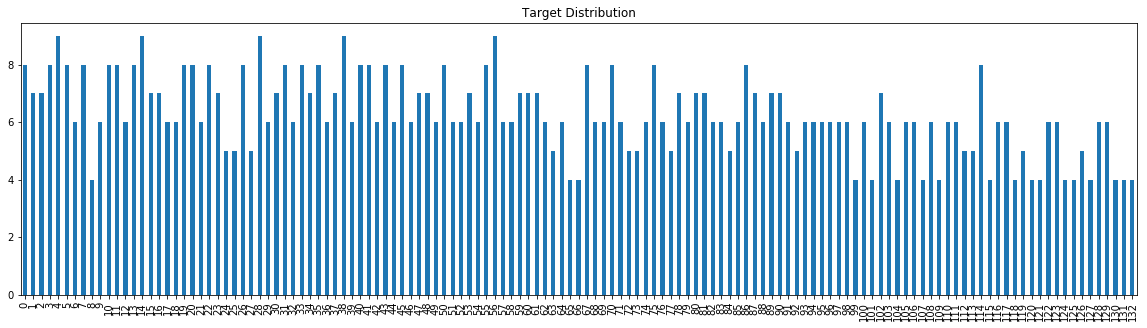

In [0]:
import pandas as pd
targets_df = pd.DataFrame(y_train, columns = ['target'])
target_count = targets_df['target'].value_counts()
target_count.sort_index().plot(kind='bar', title='Target Distribution', figsize = (20, 5));

In [0]:
class_weights = data_utils.get_class_weights(y_train)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

model = Sequential()
model.add(Dense(units=256, activation='tanh', input_dim=798))
model.add(Dropout(0.4))

model.add(Dense(units=133, activation='softmax'))



In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 100

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath=WEIGHTS_FILE, 
                               verbose=0, save_best_only=True)

history = model.fit(X_train, 
                    y_train, 
                    class_weight = class_weights,
                    validation_data=(X_test, y_test),
                    epochs=epochs, 
                    batch_size=32, 
                    callbacks=[checkpointer], 
                    verbose=0)

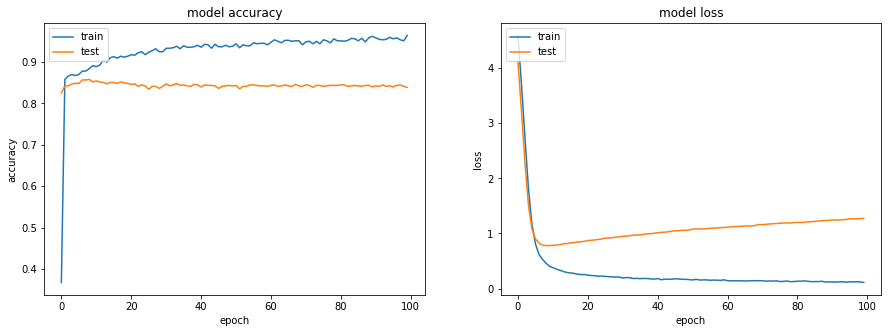

Test accuracy: 85.1675%
Training time: 53.3998% minutes


In [0]:
model_utils.plot_history(history, 'sparse_categorical_accuracy', 'val_sparse_categorical_accuracy')

accuracy = model_utils.eval_model(model, WEIGHTS_FILE, X_test, y_test, False)
print('Test accuracy: %.4f%%' % accuracy)

end_time = time.time() - start_time
print('Training time: %.4f%% minutes' % (end_time / 60))


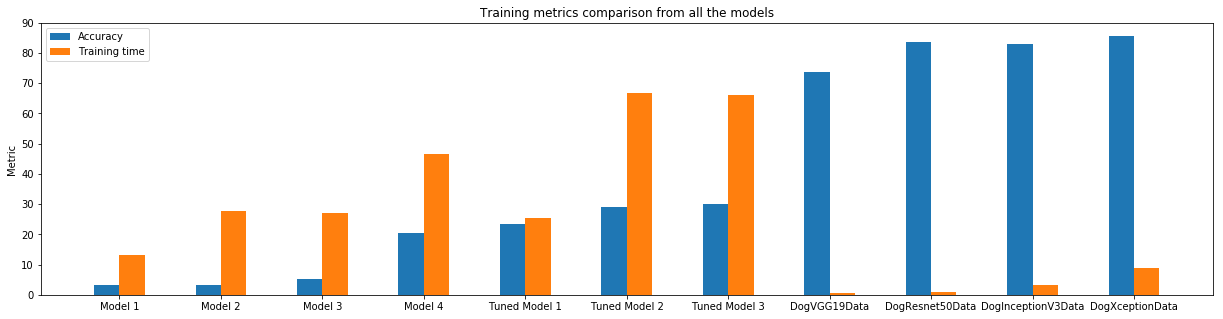

In [8]:
import matplotlib.pyplot as plt
import numpy as np

N = 11
accuracy = (3.3493, 3.2297, 5.1435, 20.5742, 23.32, 29.18, 30.14, 73.68, 83.49, 83.01, 85.64)
training_time = (13.2768, 27.5621, 26.9083, 46.4994, 25.46, 66.69, 66.24, 0.67, 0.97, 3.12, 8.78)

ind = np.arange(N) 
width = 0.25    
plt.subplots(1, 1, figsize=(21, 5))
plt.bar(ind, accuracy, width, label='Accuracy')
plt.bar(ind + width, training_time, width, label='Training time')

plt.ylabel('Metric')
plt.title('Training metrics comparison from all the models')

plt.xticks(ind + width / 2, ('Model 1', 'Model 2', 'Model 3', 'Model 4', 'Tuned Model 1', 'Tuned Model 2', 'Tuned Model 3', 'DogVGG19Data', 'DogResnet50Data', 'DogInceptionV3Data', 'DogXceptionData'))
plt.legend(loc='best')
plt.show()

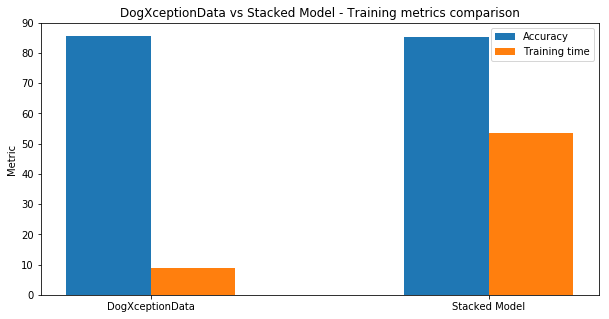

In [9]:
import matplotlib.pyplot as plt
import numpy as np

N = 2
accuracy = (85.64, 85.16)
training_time = (8.78, 53.39)

ind = np.arange(N) 
width = 0.25    
plt.subplots(1, 1, figsize=(10, 5))
plt.bar(ind, accuracy, width, label='Accuracy')
plt.bar(ind + width, training_time, width, label='Training time')

plt.ylabel('Metric')
plt.title('DogXceptionData vs Stacked Model - Training metrics comparison')

plt.xticks(ind + width / 2, ('DogXceptionData', 'Stacked Model'))
plt.legend(loc='best')
plt.show()

Test accuracy: 85.5263%